In [1]:
from fenics import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
set_log_level(30)
import random
from dolfin import interpolate, Expression, FunctionSpace, Constant, UserExpression
import os
import numpy as np

In [2]:
os.chdir('/home/erick/Desktop/Doctorado/doctorado_efsg/pruebas')

In [3]:
class RandomExpression(UserExpression):
    def __init__(self, min_val, max_val, **kwargs):
        super().__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val

    def eval(self, value, x):
        value[0] = random.uniform(self.min_val, self.max_val)

In [4]:
def NonlinearSolver(F, field):
    J = derivative(F, field)
    problem = NonlinearVariationalProblem(F, field, bcs=[], J = J)  # Add boundary conditions if needed
    solver = NonlinearVariationalSolver(problem)
    solver.parameters["snes_solver"]["method"] = "vinewtonrsls"
    solver.parameters["snes_solver"]["maximum_iterations"] = 2000  # or a higher value
    solver.parameters["snes_solver"]["relative_tolerance"] = 1e-8  # or a smaller value
    solver.parameters["snes_solver"]["linear_solver"] = "gmres"
    solver.parameters["snes_solver"]["preconditioner"] = "none"
    
    return solver

In [5]:
def field_to_numpy_array(fenics_field, coordinates_size, step, field_name, nb): 
    field_array = np.empty((0, coordinates_size), int)
    lista = []
    for val_x in range(0,coordinates_size):
        for val_y in range(0,coordinates_size):
            try:
                valor=fenics_field(val_x,val_y)
                lista.append(valor)
            except:
                lista.append(0)

            if len(lista) == coordinates_size:
                field_array = np.append(field_array, np.array([lista]), axis=0)
                if val_x < coordinates_size:
                    lista = []
    N_field = "matrix_"  + field_name +"_"+ str(step) + "_" + "nb_" + str(nb) + ".txt"
    np.savetxt(N_field, field_array, delimiter="\t")
    return None

In [6]:
def plot_fields(field_1, field_2, field_3):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 3, 1)
    p1 = plot(field_1)
    p1.set_cmap("seismic")
    plt.title(f'Solution for c at time {t:.2f}')
    aspect = 20
    pad_fraction = 0.5
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.colorbar(p1, cax=cax)


    plt.subplot(1, 3, 2)
    p2 = plot(field_2)
    p2.set_cmap("gray")
    plt.title(f'Solution for s at time {t:.2f}')
    aspect = 20
    pad_fraction = 0.5
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.colorbar(p2, cax=cax)
    
    plt.subplot(1, 3, 3)
    p3 = plot(field_3)
    p3.set_cmap("viridis")
    plt.title(f'Solution for i at time {t:.2f}')
    aspect = 20
    pad_fraction = 0.5
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.colorbar(p3, cax=cax)

    plt.tight_layout(pad=4)
    plt.show()

In [7]:
def create_space_function(space_size):

    # Create mesh and define function space
    p0 = Point(0.0, 0.0)
    p1 = Point(space_size,space_size)
    mesh = RectangleMesh(p0, p1, 200, 200,"right/left")

    V = FunctionSpace(mesh, 'P', 1)
    return V



In [8]:
def solve_dynamics():

    # Define functions for c, s, and i
    V = create_space_function(space_size)

    c = Function(V)
    s = Function(V)
    i = Function(V)
    phi_c = TestFunction(V)
    phi_s = TestFunction(V)
    phi_i = TestFunction(V)

    # Define the Jacobian, variational problem and solver for each problem
    # # Define the weak forms for the equations with time dependence

    c_n = interpolate(RandomExpression(min_val=0, max_val=0.1, degree=2), V)

    F_c = ((c - c_n) / dt) * phi_c * dx + D_c * dot(grad(c), grad(phi_c)) * dx + \
          c * (c - alle) * (1 - c) * phi_c * dx - alpha * c * s * phi_c * dx - beta * i * c * phi_c * dx

    solver_c = NonlinearSolver(F_c, c)



    s_n = interpolate(RandomExpression(min_val=0, max_val=0.8, degree=2), V)

    F_s = ((s - s_n) / dt) * phi_s * dx + D_s * dot(grad(s), grad(phi_s)) * dx + \
          s * (1 - s) * phi_s * dx - gamma * s * c * phi_s * dx + delta * s * i * phi_s * dx
    solver_s = NonlinearSolver(F_s, s)


    i_n = interpolate(RandomExpression(min_val=0, max_val=0.2, degree=2), V)

    F_i = ((i - i_n) / dt) * phi_i * dx + D_i * dot(grad(i), grad(phi_i)) * dx + \
          i * (1 - i)* phi_i * dx + eta * c * i * phi_i * dx

    solver_i = NonlinearSolver(F_i, i)
    
    return solver_c, solver_s, solver_i, c, s, i, c_n, s_n, i_n, dx

In [9]:
def c_s_i_integral(c, s, i, dx, dt):
    # Create mesh and define function space
    p0 = Point(0.0, 0.0)
    p1 = Point(space_size,space_size)
    mesh = RectangleMesh(p0, p1, 200, 200,"right/left")
        
#     dx_measure = Measure('dx', domain=mesh)
#     dx_numeric = assemble(1*dx_measure)
    
    c_int = assemble(c*dx)
    s_int = assemble(s*dx)
    i_int = assemble(i*dx)
    return c_int, s_int, i_int

In [10]:
def plot_integral(array, campo, block):
    x = array[:,0]
    y = array[:, 1]
    # Crear el gráfico
    plt.plot(x, y, label='Integral de {campo}'.format(campo=campo), marker='o')
    # Add labels and a legend
    plt.xlabel('time step')
    plt.ylabel('{campo}'.format(campo=campo))
    plt.legend()
    plt.show()
    array = array.astype(float)
    np.savetxt('int_{campo}_{block}.txt'.format(campo=campo, block=block), array) 

In [11]:
# Define constants alpha and beta
D_c = Constant(0.5)
D_s = Constant(1)
D_i = Constant(1)
ri = Constant(0.6)
rs = Constant(0.8)
gamma = Constant(0.054)
delta = Constant(0.12)
alpha = Constant(0.7)
beta = Constant(0.08)
alle = Constant(0.08)
eta = Constant(0.01)


# Define time step and time interval
T = 1  # final time
dt = 0.01  # time step size
nb = 3
space_size = 40

In [12]:
for block in range(1,nb+1):
    # Time-stepping
    t = 0
    solver_c, solver_s, solver_i, c, s, i, c_n, s_n, i_n, dx = solve_dynamics()
    print('bloque',block)
    
    c_int, s_int, i_int = c_s_i_integral(c, s, i, dx, 0)

    c_int_array = np.zeros((1,2))
    c_int_array[0][0] = "{:.2f}".format(t)
    c_int_array[0][1] = c_int   

    s_int_array = np.zeros((1,2))
    s_int_array[0][0] = "{:.2f}".format(t)
    s_int_array[0][1] = s_int   

    i_int_array = np.zeros((1,2))
    i_int_array[0][0] = "{:.2f}".format(t)
    i_int_array[0][1] = i_int   
    
    while (t < T):
        t += dt

        # Solve the system for the next time step
        solver_c.solve()
        solver_s.solve()
        solver_i.solve()

        # Update previous solution
        c_n.assign(c)
        s_n.assign(s)
        i_n.assign(i)
        c_int, s_int, i_int = c_s_i_integral(c, s, i, dx,dt)
        
        c_int_array = np.vstack([c_int_array, np.array(["{:.2f}".format(t), c_int])])
        s_int_array = np.vstack([s_int_array, np.array(["{:.2f}".format(t), s_int])])
        i_int_array = np.vstack([i_int_array, np.array(["{:.2f}".format(t), i_int])])

        # field_to_numpy_array(c, space_size, "{:.2f}".format(t), "c", block)
        # field_to_numpy_array(s, space_size, "{:.2f}".format(t), "s", block)
        # field_to_numpy_array(i, space_size, "{:.2f}".format(t), "i", block)
        # plot_fields(c_n, s_n, i_n)


bloque 1
bloque 2
bloque 3


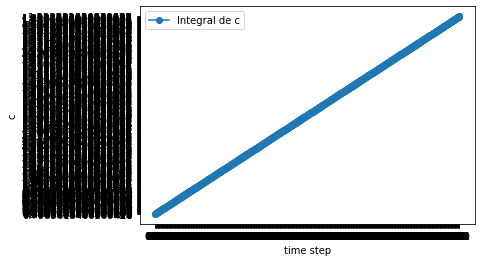

In [13]:
plot_integral(c_int_array, 'c', block)

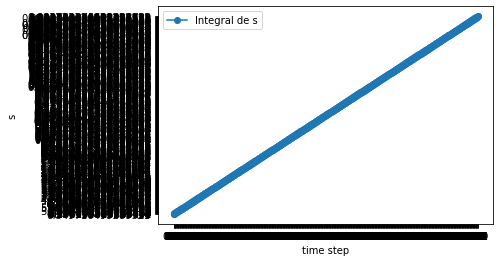

In [14]:
plot_integral(s_int_array, 's', block)

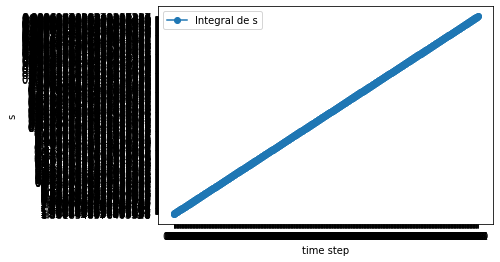

In [15]:
plot_integral(i_int_array, 's', block)

In [16]:
print(assemble(s*dx))

0.3722314659252113
